This notebook contains my replication of [this](https://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/) blog post by [Jake VanderPlas](http://vanderplas.com/) on using data from bicycle traffic across Seattle's Fremont Bridge to learn about commuting patterns.

In [12]:
import os
import ssl
from urllib.request import urlretrieve

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM
from vega_datasets import data as vega_data

from seattlecycling.data import get_fremont_data
from seattlecycling.toolbox import csnap

seaborn.set()

Helper functions

In [ ]:
fremont_url = (
    "https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD"
)


def get_fremont_data(
    filename="seattle_weather_fremont.csv", url=fremont_url, force_download=False
):
    """Download and cache the fremont bridge data

    Parameters
    ----------
    filename : string (optional)
        location to store the data
    url : string (optional)
        web location of the data
    force_download : Boolean (optional)
        if True, force redownload of data

    Returns
    -------
    data : pandas.DataFrame
        The fremont bridge data
    """
    # Solve problem with SSL certificate verification
    if not os.environ.get("PYTHONHTTPSVERIFY", "") and getattr(
        ssl, "_create_unverified_context", None
    ):
        ssl._create_default_https_context = ssl._create_unverified_context
    # Download and prepare data
    if force_download or not os.path.exists(filename):
        urlretrieve(url, filename)
    data = pd.read_csv("seattle_weather_fremont.csv", index_col="Date")
    try:
        data.index = pd.to_datetime(data.index, format="%m/%d/%Y %I:%M:%S %p")
    except TypeError:
        data.index = pd.to_datetime(data.index)
    data.columns = ["total", "west", "east"]
    return data


def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    diff = date - pd.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24.0 / 3600
    day %= 365.25
    m = 1.0 - np.tan(np.radians(latitude)) * np.tan(
        np.radians(axis) * np.cos(day * np.pi / 182.625)
    )
    m = max(0, min(m, 2))
    return 24.0 * np.degrees(np.arccos(1 - m)) / 180.0


def print_rms(var):
    """Calculates and prints the root-mean-square about the trend line"""
    rms = np.std(var)
    print("Root-mean-square about trend: {0: .0f} riders".format(rms))


def csnap(df, fn=lambda x: x.shape, msg=None):
    """
    Custom Help function to print things in method chaining.
    Returns back the df to further use in chaining.
    """
    if msg:
        print(msg)
    display(fn(df))
    return df

## Unsupervised exploration

In [9]:
# Load data

start = "1 Oct 2012"
end = "30 Jun 2015"

data = get_fremont_data()
data = data.loc[start:end]
data.head(3)

/var/folders/xg/n9p73cf50s52twlnz7z778vr0000gn/T/ipykernel_3899/1377138058.py:7: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  data = data.loc[start:end]


,total,west,east
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0


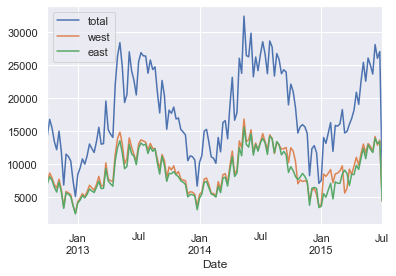

In [4]:
# A first look at the data

data.resample("w").sum().plot()

Same graph as above using Altair

In [5]:
# Create a melted dataset

melted = (
    data.resample("w")
    .sum()
    .reset_index()
    .rename(columns={"Date": "date"})
    .melt(
        id_vars="date",
        var_name=["side"],
        value_name="crossings",
        value_vars=["total", "east", "west"],
    )
)
melted.head()

,date,side,crossings
0,2012-10-07,total,14292.0
1,2012-10-14,total,16795.0
2,2012-10-21,total,15509.0
3,2012-10-28,total,13437.0
4,2012-11-04,total,12194.0


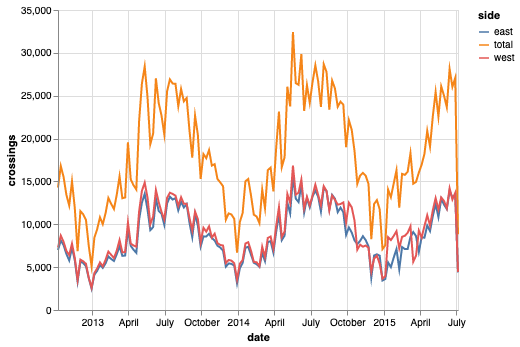

In [6]:
# Produce same graph as above

alt.Chart(melted).mark_line().encode(x="date", y="crossings", color="side")

### Visualising the data

In [7]:
# Create a datframe with days as dates and index and hours as columns
pivoted = data.pivot_table(
    ["west", "east", "total"],
    index=data.index.date,
    columns=data.index.hour,
    fill_value=0,
)
pivoted.head()

east                                     ... west                 \
Date         0  1  2  3  4   5   6    7    8    9   ...   14   15   16   17   
2012-10-03    9  6  1  3  1  10  50   95  146  104  ...   77   72  133  192   
2012-10-04   11  0  6  3  1  11  51   89  134   94  ...   63   73  114  154   
2012-10-05    7  4  3  2  2   7  37  101  119   81  ...   63   80  120  144   
2012-10-06    7  5  2  2  1   2  15   16   47   55  ...   89  115  107  107   
2012-10-07    5  5  1  2  2   3   8   12   26   36  ...  126  122  132  118   

                                     
Date         18  19  20  21  22  23  
2012-10-03  122  59  29  25  24   5  
2012-10-04  137  57  27  31  25  11  
2012-10-05  107  42  27  11  10  16  
2012-10-06   41  40  25  18  14  15  
2012-10-07   68  26  19  12   9   5  

[5 rows x 72 columns]

In [8]:
# Put raw values in a matrix

X = pivoted.values
X.shape

(1001, 72)

In [9]:
# Use PCA to reduce dimensionality (keep 90 percent of the variance)

Xpca = PCA(0.9).fit_transform(X)
Xpca.shape

(1001, 2)

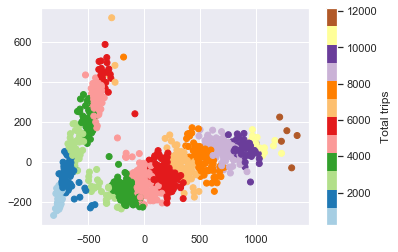

In [10]:
total_trips = X.sum(1)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips, cmap="Paired")
plt.colorbar(label="Total trips")

What can we learn from this graph? We can see that the days fall into two quite distinct cluster, one with a higher number of trips and one with a lower number of trips, that the number of trips increases along the length of each projected cluster (i.e. as we move away from the origin), and that close to the origin, the groups are less distinguishable. Overall, we can see that there are, in effect, two types of days for Seattle cyclists. This is indeed pretty cool.

### Unsupervised clustering

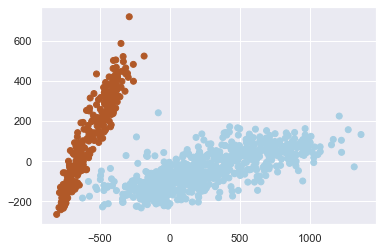

In [11]:
# Use a Gaussian mixture model to separate days into two clusters

gmm = GMM(2, covariance_type="full", random_state=0)
gmm.fit(Xpca)
cluster_label = gmm.predict(Xpca)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=cluster_label, cmap="Paired")

In [12]:
# Add cluster labels to original data

pivoted["cluster"] = cluster_label
data = data.join(pivoted["cluster"], on=data.index.date)
data.head()

,total,west,east,cluster
Date,,,,
2012-10-03 00:00:00,13.0,4.0,9.0,0
2012-10-03 01:00:00,10.0,4.0,6.0,0
2012-10-03 02:00:00,2.0,1.0,1.0,0
2012-10-03 03:00:00,5.0,2.0,3.0,0
2012-10-03 04:00:00,7.0,6.0,1.0,0


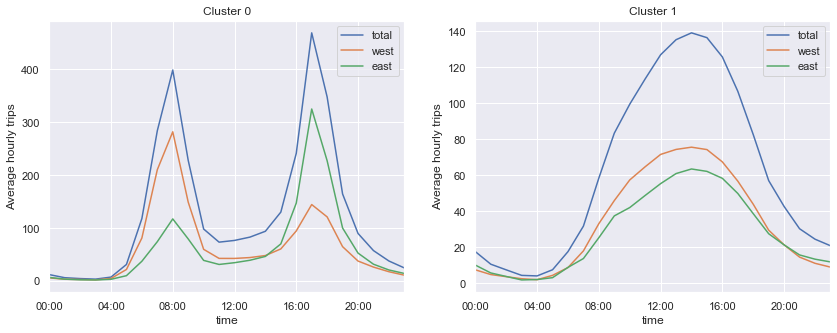

In [13]:
# Plot

hourly = data.groupby(["cluster", data.index.time]).mean()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
hourly_ticks = 4 * 60 * 60 * np.arange(6)

for i in range(2):
    hourly.loc[i].plot(ax=ax[i], xticks=hourly_ticks)
    ax[i].set_title("Cluster {0}".format(i))
    ax[i].set_ylabel("Average hourly trips")

First plot shows a sharp bimodal pattern, indicative of a communing pattern (with the majority of people riding west in the morning and east in the evening), while the second plot shows a wide unimodel pattern, indicative of weekend days and holidays. 

### Uncovering work habits

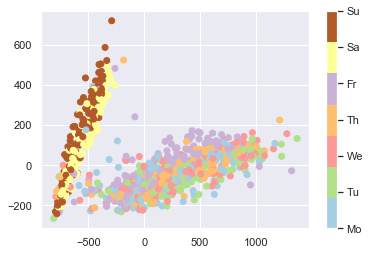

In [14]:
# Check whether two clusters correspond to weekend and weekdays

dayofweek = pd.to_datetime(pivoted.index).dayofweek

plt.scatter(Xpca[:, 0], Xpca[:, 1], c=dayofweek, cmap=plt.cm.get_cmap("Paired", 7))

cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"])

Let's look more closely at weekdays that follow a weekend pattern, of which there are a few.

In [15]:
results = pd.DataFrame(
    {
        "cluster": pivoted["cluster"],
        "is_weekend": (dayofweek > 4),
        "weekday": pivoted.index.map(lambda x: x.strftime("%a")),
    }
)
results.head()

,cluster,is_weekend,weekday
2012-10-03,0,False,Wed
2012-10-04,0,False,Thu
2012-10-05,0,False,Fri
2012-10-06,1,True,Sat
2012-10-07,1,True,Sun


Count number of weekend days with a workday pattern

In [16]:
weekend_workdays = results.query("cluster == 0 and is_weekend")
len(weekend_workdays)

0

Count number of week days that fall into the weekend / holiday pattern

In [17]:
weekday_holidays = results.query("cluster == 1 and not is_weekend")
len(weekday_holidays)

23

There were zero weekend days where people in Seattle decided to work, but 23 weekdays that appear to be public holidasy. Let's have a look.

In [18]:
# Download list of public holidays

cal = USFederalHolidayCalendar()
holidays = cal.holidays("2012", "2016", return_name=True)
holidays.head()

2012-01-02                 New Years Day
2012-01-16    Martin Luther King Jr. Day
2012-02-20                Presidents Day
2012-05-28                  Memorial Day
2012-07-04                      July 4th
dtype: object

In [19]:
# Add the days before and after holidays to the list

holidays_all = pd.concat(
    [
        holidays,
        "Day before " + holidays.shift(-1, "D"),
        "Day after " + holidays.shift(1, "D"),
    ]
)
holidays_all.sort_index(inplace=True)
holidays_all.head()

2012-01-01                 Day before New Years Day
2012-01-02                            New Years Day
2012-01-03                  Day after New Years Day
2012-01-15    Day before Martin Luther King Jr. Day
2012-01-16               Martin Luther King Jr. Day
dtype: object

In [20]:
# A list of holidays on which people in Seattle skip work

holidays_all.name = "name"
joined = weekday_holidays.join(holidays_all)
set(joined["name"])

{'Christmas',
 'Day after Christmas',
 'Day after Thanksgiving',
 'Day before Christmas',
 'July 4th',
 'Labor Day',
 'Memorial Day',
 'New Years Day',
 'Thanksgiving'}

In [21]:
# A list of holidays on which people in Seattle do go to work

set(holidays) - set(joined["name"])

{'Columbus Day',
 'Martin Luther King Jr. Day',
 'Presidents Day',
 'Veterans Day'}

### What's up with Fridays?

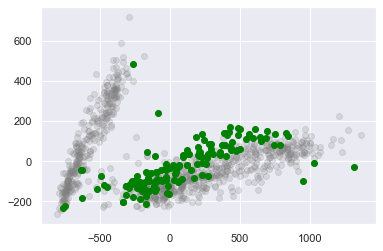

In [22]:
# Plot Fridays separately

fridays = dayofweek == 4
plt.scatter(Xpca[:, 0], Xpca[:, 1], c="gray", alpha=0.2)
plt.scatter(Xpca[fridays, 0], Xpca[fridays, 1], c="green")

What's going on with the three strange outliers in the right bottom corner?

In [23]:
# Get dates for the three outliers

weird_fridays = pivoted.index[fridays & (Xpca[:, 0] > 900)]
weird_fridays

Index([2013-05-17, 2014-05-16, 2015-05-15], dtype='object')

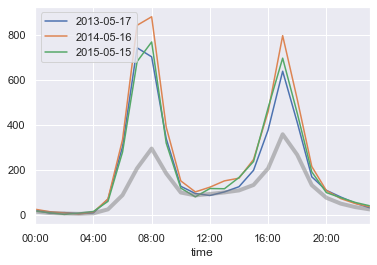

In [24]:
# Plot pattern for three outliers relative to average Friday

all_days = data.pivot_table("total", index=data.index.time, columns=data.index.date)

all_days.loc[:, weird_fridays].plot()
all_days.mean(1).plot(color="grey", lw=4, alpha=0.5, xticks=hourly_ticks)

We've found Seattle's [bike to work day](https://www.cascade.org/bikeeverywhereday).

## Supervised modeling

This notebook contains my replication of [this](https://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/) blog post by [Jake VanderPlan](http://vanderplas.com/) on using data from bicycle traffic across Seattle's Fremont Bridge to learn about commuting patterns.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from seattlecycling.data import get_fremont_data
from seattlecycling.toolbox import hours_of_daylight
from seattlecycling.toolbox import print_rms

In [2]:
# Load data

start = '1 Oct 2012'
end = '15 May 2014'

data = get_fremont_data()
data = data.loc[start:end]
data.head(3)

,total,west,east
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0


In [3]:
# Resample data into daily and weekly totals

daily = data.resample('d').sum()
weekly = data.resample('w').sum()

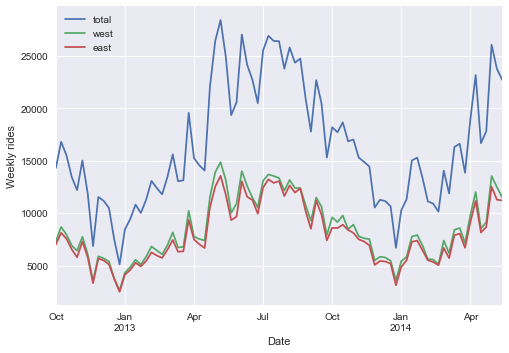

In [4]:
# A first look at the data

weekly.plot();
plt.ylabel('Weekly rides');

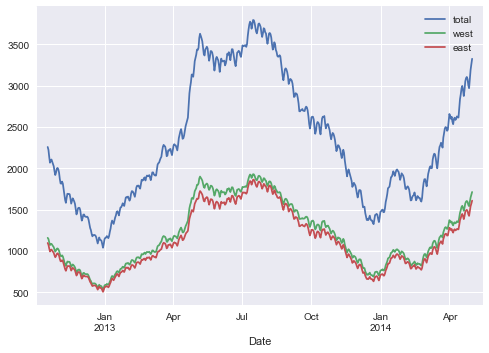

In [5]:
# Look at rolling weekly mean to smooth out short-term variation

data.resample('d').sum().rolling(30, center=True).mean().plot();

Blog post points out that 2014 has seen increased cycle traffic across the bridge. Below we're modelling seasonal variation based on what we think influences peoples' decision whether or not to ride a bike.

# Accounting for hours of daylight

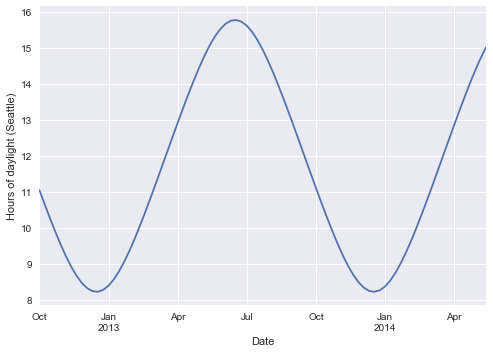

In [6]:
# Hours of daylight

weekly['daylight'] = list(map(hours_of_daylight, weekly.index))
daily['daylight'] = list(map(hours_of_daylight, daily.index))

weekly['daylight'].plot()
plt.ylabel('Hours of daylight (Seattle)');

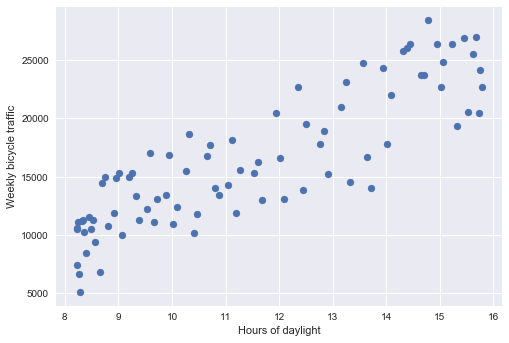

In [7]:
# Relationship between daylight and cycle traffic

plt.scatter(weekly.daylight, weekly.total)
plt.xlabel('Hours of daylight')
plt.ylabel('Weekly bicycle traffic');

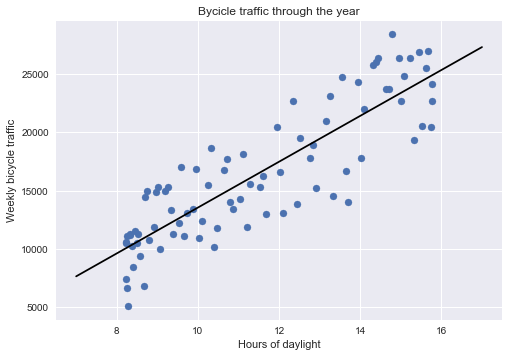

In [8]:
# Adding a linear trend

X = weekly[['daylight']]
y = weekly['total']
clf = LinearRegression(fit_intercept=True).fit(X, y)

weekly['daylight_trend'] = clf.predict(X)
weekly['daylight_corrected_total'] = weekly.total - weekly.daylight_trend + np.mean(weekly.daylight_trend)

xfit = np.linspace(7, 17)
yfit = clf.predict(xfit[:, None])

plt.scatter(weekly.daylight, weekly.total)
plt.plot(xfit, yfit, '-k')
plt.title('Bycicle traffic through the year')
plt.xlabel('Hours of daylight')
plt.ylabel('Weekly bicycle traffic');

In [9]:
clf.coef_[0]

1966.2003072317068

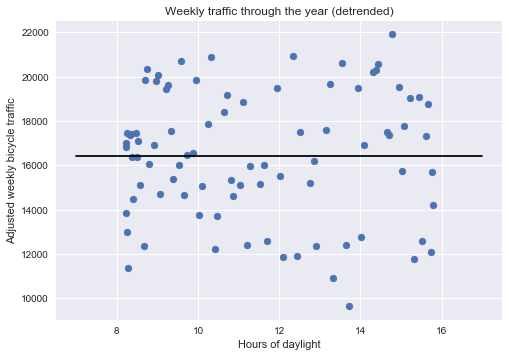

In [10]:
# Plot detrended data

trend = clf.predict(weekly[['daylight']].values)
plt.scatter(weekly.daylight, weekly.total - trend + np.mean(trend))
plt.plot(xfit, np.mean(trend) + 0 * yfit, '-k')
plt.title('Weekly traffic through the year (detrended)')
plt.xlabel('Hours of daylight')
plt.ylabel('Adjusted weekly bicycle traffic');

In the graph above, we have removed the number of riders per week that correlate with the number of hours of daylight, so that we can think of what is shown of the number of rides per week we'd expect to see if daylight was not an issue.

Root-mean-square about trend:  2872 riders


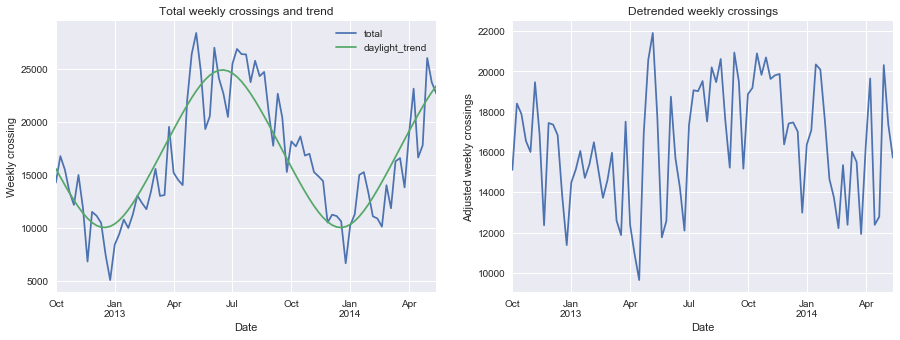

In [11]:
fix, ax = plt.subplots(1, 2, figsize=(15,5))

weekly[['total', 'daylight_trend']].plot(ax=ax[0])
weekly['daylight_corrected_total'].plot(ax=ax[1])

ax[0].set_ylabel('Weekly crossing')
ax[0].set_title('Total weekly crossings and trend')
ax[1].set_ylabel('Adjusted weekly crossings')
ax[1].set_title('Detrended weekly crossings')

print_rms(weekly['daylight_corrected_total'])

# Accounting for day of the week

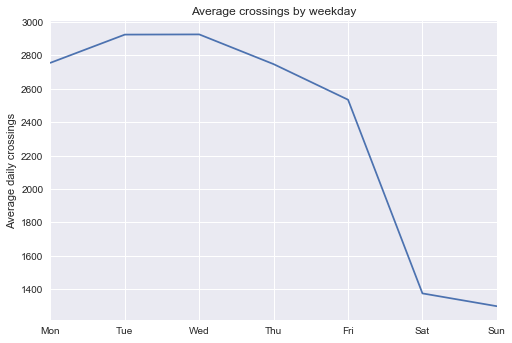

In [12]:
# Plot average number of trips by weekday

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily['dayofweek'] = daily['total'].index.dayofweek
grouped = daily.groupby('dayofweek')['total'].mean()
grouped.index = days

grouped.plot()
plt.title('Average crossings by weekday')
plt.ylabel('Average daily crossings');

In [13]:
# Account for hours of daylight and day of week simultaneously

# Add one-hot indicators of weekdays
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)
    
# Detrend on days of week and daylight together
X = daily[days + ['daylight']]
y = daily['total']
clf = LinearRegression().fit(X, y)

daily['dayofweek_trend'] = clf.predict(X)
daily['dayofweek_corrected'] = daily['total'] - daily['dayofweek_trend'] + daily['dayofweek_trend'].mean()

Root-mean-square about trend:  652 riders


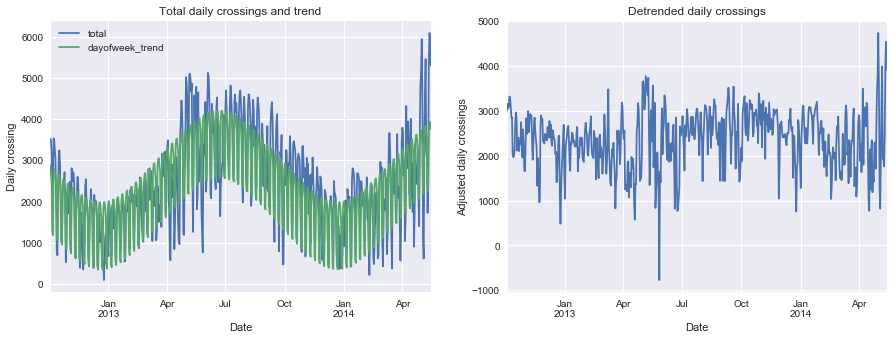

In [14]:
# Plot crossings and trend, and detrended data

fix, ax = plt.subplots(1, 2, figsize=(15,5))

daily[['total', 'dayofweek_trend']].plot(ax=ax[0])
daily['dayofweek_corrected'].plot(ax=ax[1])

ax[0].set_ylabel('Daily crossing')
ax[0].set_title('Total daily crossings and trend')
ax[1].set_ylabel('Adjusted daily crossings')
ax[1].set_title('Detrended daily crossings')

print_rms(daily['dayofweek_corrected'])

# Accounting for rainfall and temparature

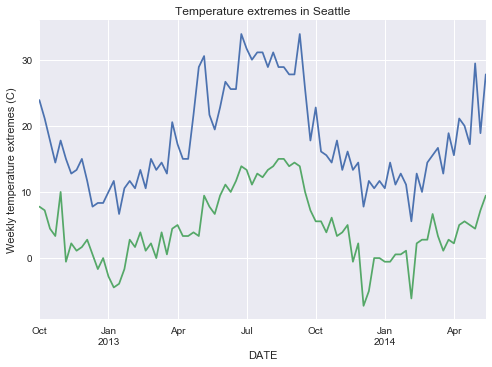

In [15]:
# Read in weather data
weather = pd.read_csv('SeaTacWeather.csv', index_col='DATE', 
                      parse_dates=True, usecols=[2, 5, 9, 10])
weather = weather.loc[start:end]
weather.columns = map(str.lower, weather.columns)

# Temparatures are in 1/10 deg F; convert to deg C
weather['tmax'] = (weather['tmax'] - 32) * 5/9
weather['tmin'] = (weather['tmin'] -32) * 5/9

# Rainfall is in inches; convert to mm
weather['prcp'] *= 25.4

weather['tmax'].resample('w').max().plot()
weather['tmin'].resample('w').min().plot()
plt.title('Temperature extremes in Seattle')
plt.ylabel('Weekly temperature extremes (C)');

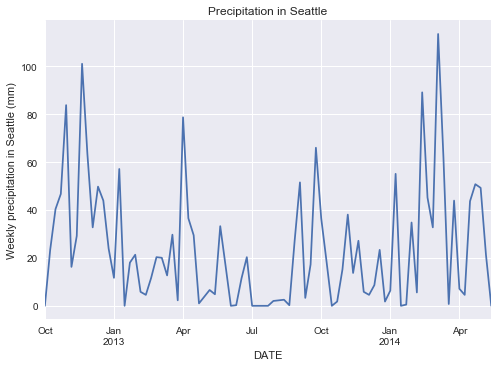

In [16]:
weather['prcp'].resample('w').sum().plot()
plt.title('Precipitation in Seattle')
plt.ylabel('Weekly precipitation in Seattle (mm)');

In [17]:
# Combine daily and weather dataset

daily = daily.join(weather)

In [18]:
# Detrend data including weather information

columns = days + ['daylight', 'tmax', 'tmin', 'prcp']
X = daily[columns]
y = daily['total']
clf = LinearRegression().fit(X, y)

daily['overall_trend'] = clf.predict(X)
daily['overall_corrected'] = daily['total'] - daily['overall_trend'] + daily['overall_trend'].mean()

Root-mean-square about trend:  457 riders


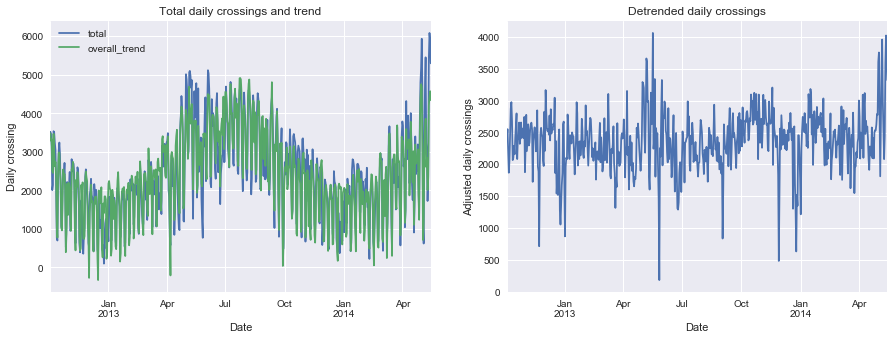

In [19]:
# Plot crossings and trend, and detrended data
fix, ax = plt.subplots(1, 2, figsize=(15,5))

daily[['total', 'overall_trend']].plot(ax=ax[0])
daily['overall_corrected'].plot(ax=ax[1])

ax[0].set_ylabel('Daily crossing')
ax[0].set_title('Total daily crossings and trend')
ax[1].set_ylabel('Adjusted daily crossings')
ax[1].set_title('Detrended daily crossings')

print_rms(daily['overall_corrected'])

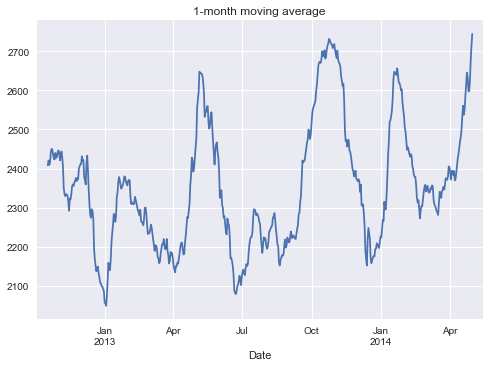

In [20]:
# Plot rolling 30 day average

daily['overall_corrected'].rolling(30, center=True).mean().plot();
plt.title('1-month moving average');

# Accounting for a steady increase in riders

In [21]:
daily['daycount'] = np.arange(len(daily))

columns = days + ['daycount', 'daylight', 'tmax', 'tmin', 'prcp']
X = daily[columns]
y = daily['total']
final_model = LinearRegression().fit(X, y)

daily['final_trend'] = final_model.predict(X)
daily['final_corrected'] = daily['total'] - daily['final_trend'] + daily['final_trend'].mean()

Root-mean-square about trend:  451 riders


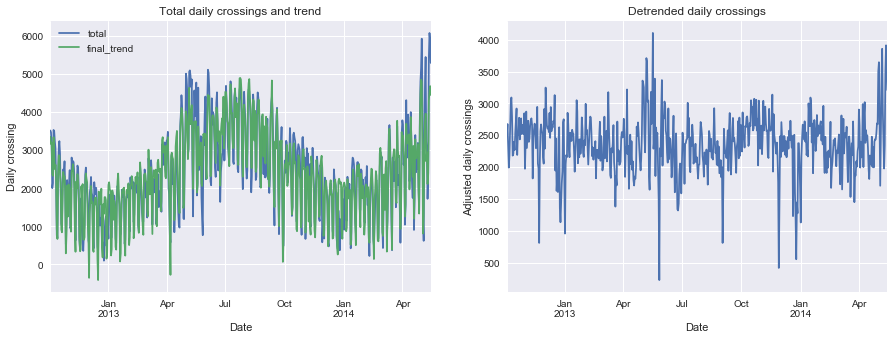

In [22]:
# Plot crossings and trend, and detrended data
fix, ax = plt.subplots(1, 2, figsize=(15,5))

daily[['total', 'final_trend']].plot(ax=ax[0])
daily['final_corrected'].plot(ax=ax[1])

ax[0].set_ylabel('Daily crossing')
ax[0].set_title('Total daily crossings and trend')
ax[1].set_ylabel('Adjusted daily crossings')
ax[1].set_title('Detrended daily crossings')

print_rms(daily['final_corrected'])

# What can the final model tell us?

In [23]:
# Compute error variance

vy = np.sum((y - daily['final_trend']) ** 2) / len(y)
X2 = np.hstack([X, np.ones((X.shape[0], 1))])
C = vy * np.linalg.inv(np.dot(X2.T, X2))
var = C.diagonal()

### How does rain affect ridership?

In [24]:
ind = columns.index('prcp')
slope = final_model.coef_[ind]
error = np.sqrt(var[ind])
print('{0: .0f} +/- {1: .0f} daily crossings lost per cm of rain'.format(-slope * 10, error * 10))

 331 +/-  28 daily crossings lost per cm of rain


The model shows that for every cm of rain, about 300 cyclists stay home or use another mode of transport.

### How does temparature affect ridership?

In [25]:
ind1, ind2 = columns.index('tmin'), columns.index('tmax')
slope = final_model.coef_[ind1] + final_model.coef_[ind2]
error = np.sqrt(var[ind1] + var[ind2])
print('{0:.0f} +/- {1:.0f} riders per ten degrees Celsius'.format(10 * slope, 10 * error))

493 +/- 102 riders per ten degrees Celsius


### How does daylight affect ridership?

In [26]:
ind = columns.index('daylight')
slopt = final_model.coef_[ind]
error = np.sqrt(var[ind])
print('{0:.0f} +/- {1:.0f} riders per hour of daylight'.format(slope, error))

49 +/- 12 riders per hour of daylight


### Is ridership increasing?

In [27]:
ind = columns.index('daycount')
slope = final_model.coef_[ind]
error = np.sqrt(var[ind])
print("{0:.2f} +/- {1:.2f} new riders per day".format(slope, error))
print("{0:.1f} +/- {1:.1f} new riders per week".format(7 * slope, 7 * error))
print("annual change: ({0:.0f} +/- {1:.0f})%".format(100 * 365 * slope / daily['total'].mean(),
                                                    100 * 365 * error / daily['total'].mean()))

0.43 +/- 0.11 new riders per day
3.0 +/- 0.8 new riders per week
annual change: (7 +/- 2)%
